In [1]:
env = "colab"

# **Config**

In [2]:
import os

if env.lower() == "colab":
  from google.colab import drive
  drive.mount('/content/drive')
  ROOT_PATH = "/content/drive/MyDrive/ML4FIN/"
  os.chdir(ROOT_PATH) # cd into directory
  print(os.listdir(".")) # Check the content of current folder
  !pip install transformers
  !pip install datasets


Mounted at /content/drive
['sa_index.ipynb', 'colab-requirements.txt', 'data', 'models', 'finetuning.ipynb', 'paraphraser.ipynb', 'tmp_trainer', 'Copie de finetuning.ipynb', 'monthly_df_mean_sum_2.jsonl']
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0,

In [3]:
from datasets import load_dataset
from transformers import pipeline

# **Predict Scores**

In [5]:
model = "MAPAi/InflaBERT"

pipe = pipeline("text-classification", model=model, return_all_scores=True, batch_size=64, device='cuda:0')

In [19]:
ds = load_dataset("MAPAi/inflation_news")['train']
ds

Dataset({
    features: ['summary', 'date'],
    num_rows: 12489
})

#### **Predict Simple Probabilities**

In [8]:
preds = pipe(ds['summary'])
preds[0]

[{'label': 'negative', 'score': 0.000481515220599249},
 {'label': 'neutral', 'score': 0.9979469180107117},
 {'label': 'positive', 'score': 0.0015715208137407899}]

### **Probabilities to Polarity Score**

In [20]:
import numpy as np

label2id = {'negative': -1, 'neutral': 0, 'positive': 1}

polarity_scores = []

for p in preds:
  polarity_score = np.sum([label2id[d['label']]*(d['score']) for d in p])
  polarity_scores.append(polarity_score)

ds = ds.add_column("polarity_scores", polarity_scores)
ds

Dataset({
    features: ['summary', 'date', 'polarity_scores'],
    num_rows: 12489
})

### **Probabilities to Argmax Score**

In [21]:
import numpy as np

label2id = {'negative': -1, 'neutral': 0, 'positive': 1}

polarity_scores_am = []

for p in preds:
  max_index = np.argmax([d['score'] for d in p])
  polarity_scores_am.append(label2id[p[max_index]['label']])

ds = ds.add_column("polarity_scores_am", polarity_scores_am)
ds


# Get the label of the dictionary with the maximum score


Dataset({
    features: ['summary', 'date', 'polarity_scores', 'polarity_scores_am'],
    num_rows: 12489
})

In [22]:
import pandas as pd

df = pd.DataFrame(ds)
df['date'] = df['date'].dt.to_period('M')
df

<ipython-input-22-169a61adaf90>:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['date'] = df['date'].dt.to_period('M')


,summary,date,polarity_scores,polarity_scores_am
0,"Today, the United States wakes up at 2, smokes...",2010-01,0.001090,0
1,"Today, the United States wakes up at 2, smokes...",2010-01,0.000423,0
2,Disclosure: Long gold and silver via GLD and S...,2010-02,0.999074,1
3,Even independent oil and gas companies like An...,2010-02,0.999533,1
4,Short treasuries via TBT. That 4.7% return on ...,2010-02,0.999225,1
...,...,...,...,...
12484,That brings the rig count down from a post-pan...,2023-12,-0.991342,-1
12485,Along with the healthy operating fundamentals ...,2023-12,-0.330590,-1
12486,"To that point, a more dovish Fed is starting t...",2023-12,0.999285,1
12487,The S&P 500 hit a new high for the year lately...,2023-12,-0.999210,-1


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid')

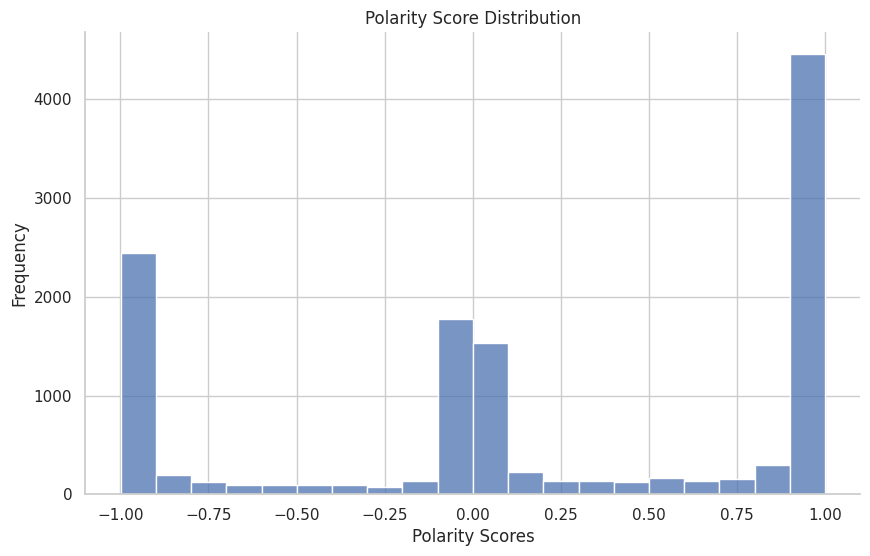

In [28]:
# Assuming df is already defined and loaded with data
plt.figure(figsize=(10, 6))
sns.histplot(df['polarity_scores'], bins=20, kde=False)
plt.title('Polarity Score Distribution')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Polarity Scores')
plt.ylabel('Frequency')
plt.show()


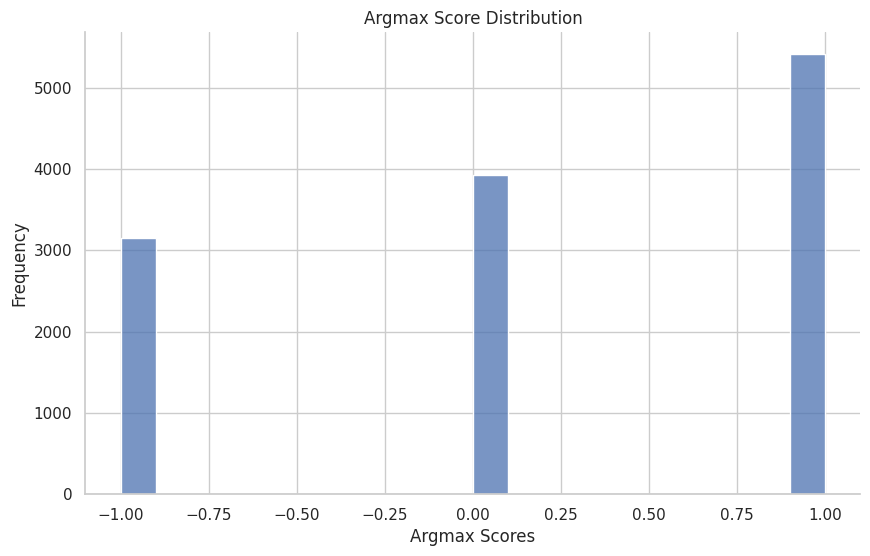

In [29]:
# Assuming df is already defined and loaded with data
plt.figure(figsize=(10, 6))
sns.histplot(df['polarity_scores_am'], bins=20, kde=False)
plt.title('Argmax Score Distribution')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Argmax Scores')
plt.ylabel('Frequency')
plt.show()


In [14]:
# Group by 'date' and aggregate
monthly_df = df[['date', 'polarity_scores']].groupby('date')['polarity_scores'].mean().reset_index()

# Convert date back
monthly_df['date'] = pd.to_datetime(monthly_df['date'].astype(str))

# Compute the cumulative sum
#monthly_df['polarity_scores'] = monthly_df['polarity_scores'].rolling(window=6).mean()
monthly_df['NEWS'] = monthly_df['polarity_scores'].cumsum() + 100

# Compute % changes
T = 12
monthly_df['pi-NEWS'] = 100 * monthly_df['NEWS'].pct_change(periods=T) + 2

# Display the DataFrame
#monthly_df = monthly_df.dropna()
monthly_df

,date,polarity_scores,NEWS,pi-NEWS
0,2010-01-01,0.000757,100.000757,NaN
1,2010-02-01,0.598613,100.599369,NaN
2,2010-03-01,0.064623,100.663992,NaN
3,2010-04-01,0.422778,101.086770,NaN
4,2010-05-01,-0.012980,101.073790,NaN
...,...,...,...,...
163,2023-08-01,0.072001,113.206184,2.845236
164,2023-09-01,0.132535,113.338719,2.831835
165,2023-10-01,0.145935,113.484654,2.852729
166,2023-11-01,0.102272,113.586926,2.859713


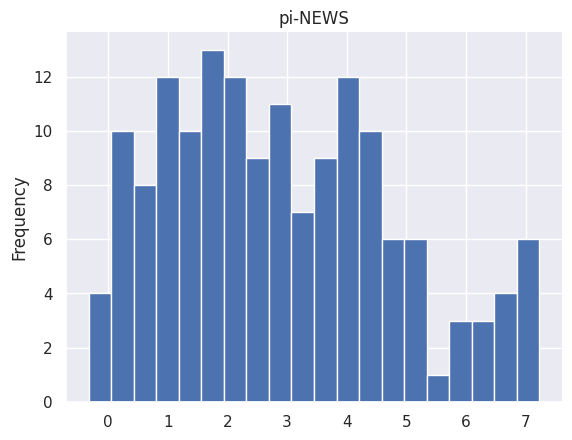

In [15]:
# @title pi-NEWS

from matplotlib import pyplot as plt
monthly_df['pi-NEWS'].plot(kind='hist', bins=20, title='pi-NEWS')
plt.gca().spines[['top', 'right',]].set_visible(False)

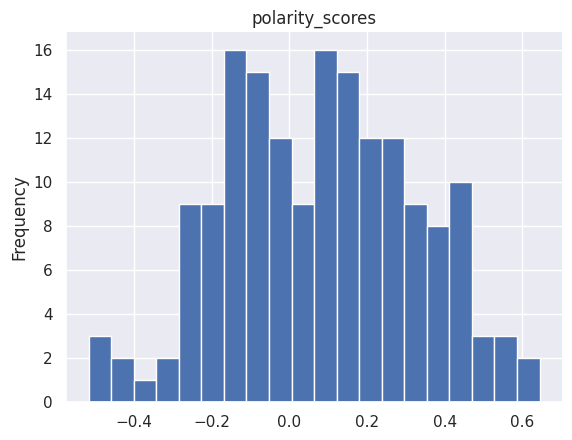

In [ ]:
# @title polarity_scores

from matplotlib import pyplot as plt
monthly_df['polarity_scores'].plot(kind='hist', bins=20, title='polarity_scores')
plt.gca().spines[['top', 'right',]].set_visible(False)

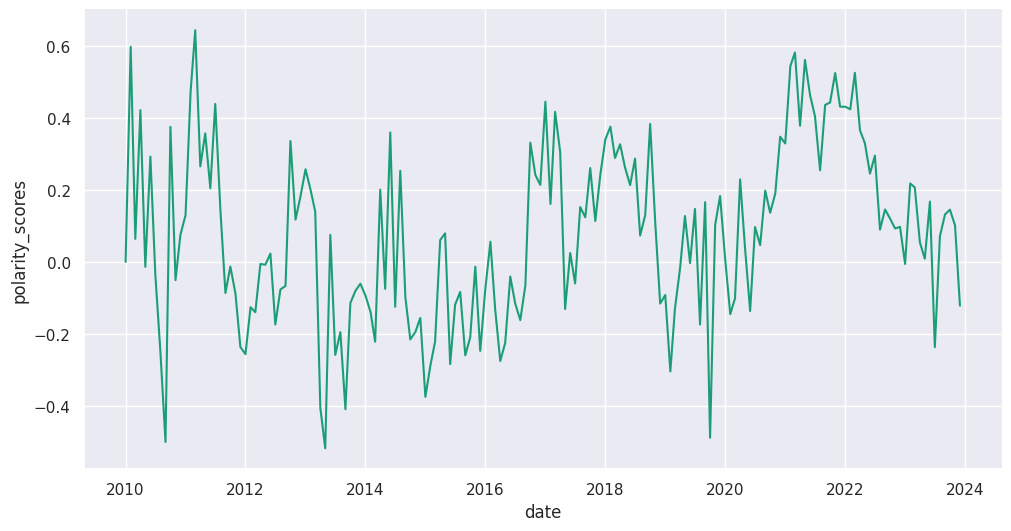

In [ ]:
# @title date vs polarity_scores

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['polarity_scores']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = monthly_df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('polarity_scores')

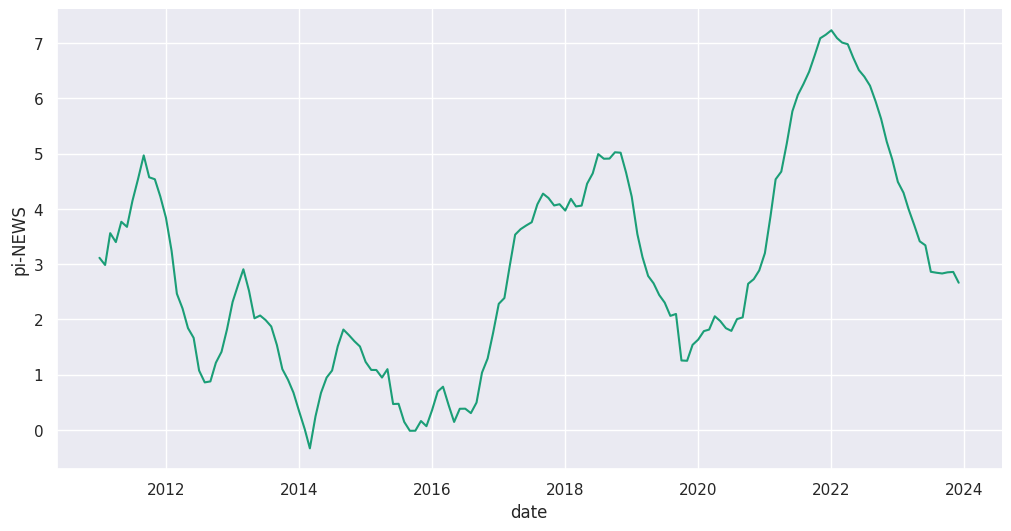

In [ ]:
# @title date vs pi-NEWS

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['pi-NEWS']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = monthly_df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('pi-NEWS')

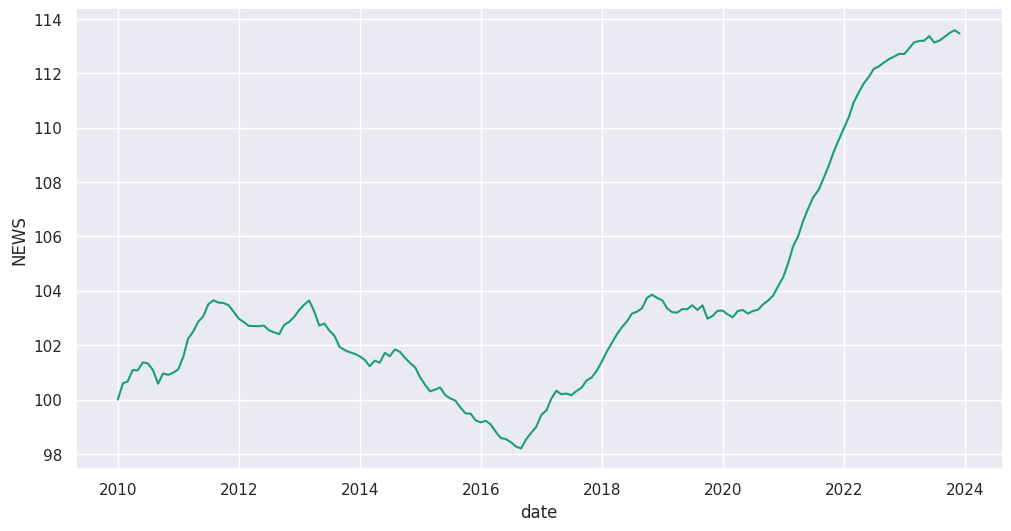

In [ ]:
# @title date vs NEWS

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['NEWS']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = monthly_df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('NEWS')

In [ ]:
from datasets import Dataset

ds = Dataset.from_pandas(monthly_df[['date', 'NEWS']])

ds.to_json("data/news_index.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

7522